In [29]:
import pandas as pd
import torch
from chronos import ChronosPipeline
import numpy as np
import timesfm

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame


pipeline_choronos_t5_large = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cuda:0",
          per_core_batch_size=32,
          horizon_len=50,
          input_patch_len=32,
          output_patch_len=128,
          num_layers=50,
          model_dims=1280,
          use_positional_embedding=False,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )


def split_series(series, segment_len=500):
    if isinstance(series, list):
        series = torch.tensor(series, dtype=torch.float32)
    elif isinstance(series, torch.Tensor):
        series = series.to(torch.float32)
    else:
        raise ValueError("Input must be list or tensor")
    
    n = len(series)
    segments = []
    for start in range(0, n - segment_len + 1, segment_len):
        segments.append(series[start:start + segment_len])
    return segments

def predict_next_50(time_series, pipeline):
    if isinstance(time_series, list):
        time_series = torch.tensor(time_series, dtype=torch.float32)
    elif isinstance(time_series, torch.Tensor):
        time_series = time_series.to(torch.float32)
    else:
        raise ValueError("Input must be list or tensor")
    
    if time_series.ndim != 1:
        raise ValueError("Input series must be 1D")
    if len(time_series) < 450:
        raise ValueError("Input series length must be at least 450")
    
    input_segment = time_series[:450].unsqueeze(0)
    forecast = pipeline.predict(input_segment, prediction_length=50)
    return forecast.squeeze(0).squeeze(0).detach().cpu().numpy()

def predict_next_50_bolt(time_series, pipeline):
    if isinstance(time_series, list):
        time_series = torch.tensor(time_series, dtype=torch.float32)
    elif isinstance(time_series, torch.Tensor):
        time_series = time_series.to(torch.float32)
    else:
        raise ValueError("Input must be list or tensor")
    
    if time_series.ndim != 1:
        raise ValueError("Input series must be 1D")
    if len(time_series) < 450:
        raise ValueError("Input series length must be at least 450")
    
    # Formalized it
    input_segment = pd.DataFrame(time_series[:450].numpy(), columns=["target"])
    input_segment["item_id"] = "series_basic"
    input_segment["timestamp"] = pd.date_range(start="2020-01-01", periods=len(input_segment), freq="D")
    input_segment = input_segment[["item_id", "timestamp", "target"]]
    
    predictor  = pipeline.fit(
        input_segment,
        hyperparameters={
            "Chronos": {"model_path": "amazon/chronos-bolt-base"},
        },
    )
    predictions = predictor.predict(input_segment)
    return predictions["mean"].to_numpy()

from sklearn.linear_model import LinearRegression
def linear_trend_forecast(series, horizon):
    series = np.asarray(series)
    n = len(series)
    X = np.arange(n).reshape(-1,1)
    y = series
    model = LinearRegression()
    model.fit(X, y)
    X_future = np.arange(n, n+horizon).reshape(-1,1)
    forecast = model.predict(X_future)
    return forecast


def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # 避免除零，加个小常数
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100


def sMAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2

    denominator = np.clip(denominator, 1e-8, None)
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100


def weighted_quantile_loss(y_true, y_pred, quantile=0.5, weight=1.0):

    diff = y_true - y_pred
    return np.mean(weight * np.maximum(quantile * diff, (quantile - 1) * diff))

def Agg_Relative_WQL(y_true, y_pred, base_pred, quantiles=[0.1, 0.5, 0.9], weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    base_pred = np.array(base_pred)
    if weights is None:
        weights = np.ones(len(quantiles)) / len(quantiles)
    agg_relative_wql_sum = 0
    for q, w in zip(quantiles, weights):
        q_pred = y_pred
        base_q_pred = base_pred
        wql = weighted_quantile_loss(y_true, q_pred, quantile=q)
        base_wql = weighted_quantile_loss(y_true, base_q_pred, quantile=q)
        agg_relative_wql_sum += w * (wql / (base_wql + 1e-8))
    return agg_relative_wql_sum


def MASE(y_true, y_pred, y_train, seasonality=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_train = np.array(y_train)
    n = len(y_train)
    d = np.abs(y_train[seasonality:] - y_train[:-seasonality]).mean()
    errors = np.abs(y_true - y_pred)
    return errors.mean() / (d + 1e-8)

def Agg_Relative_MASE(y_true, y_pred, base_pred, y_train, seasonality=1):
    model_mase = MASE(y_true, y_pred, y_train, seasonality)
    base_mase = MASE(y_true, base_pred, y_train, seasonality)
    return model_mase / (base_mase + 1e-8)


def predict_long_series(series):

    seasonality = 1
    segments = split_series(series, 500)
    
    all_metrics = []
    seg_id = 0
    for seg in segments:
        # This is for amazon/chronos-bolt-base
        pipeline_choronos_bolt_base = TimeSeriesPredictor(prediction_length=50)
        pred_choronos_bolt = predict_next_50_bolt(seg[:450], pipeline_choronos_bolt_base)

        # This is for amazon/chronos-t5-large
        pred_choronos_t5 = predict_next_50(seg[:450], pipeline_choronos_t5_large)

        # This is for linear tnd model
        pred_linear_trend = linear_trend_forecast(seg[:450].cpu().numpy(), 50)

        # This is for timesfm
        input_tensor = seg[:450].unsqueeze(0).detach().cpu().numpy()
        pred_timesfm = np.squeeze(tfm.forecast(input_tensor, [0])[0])
    
        y_train = seg[:450].cpu().numpy()
        ground_truth = seg[450:].cpu().numpy()
        
        segment_metrics = {}
        for name, pred in [
                ('chronos_bolt', pred_choronos_bolt),
                ('chronos_t5', pred_choronos_t5),
                ('linear_trend', pred_linear_trend),
                ('timesfm', pred_timesfm)
        ]:
            mape = MAPE(ground_truth, pred)
            smape = sMAPE(ground_truth, pred)
            agg_wql = Agg_Relative_WQL(ground_truth, pred, pred_linear_trend) 
            agg_mase = Agg_Relative_MASE(ground_truth, pred, pred_linear_trend, y_train, seasonality)

            print(f"{name} - MAPE: {mape:.4f}%, sMAPE: {smape:.4f}%, Agg. Relative WQL: {agg_wql:.4f}, Agg. Relative MASE: {agg_mase:.4f}\n")
            segment_metrics[name] = {
                "MAPE": mape,
                "sMAPE": smape,
                "Agg_Relative_WQL": agg_wql,
                "Agg_Relative_MASE": agg_mase,
            }
            segment_metrics["seg_id"] = seg_id
        all_metrics.append(segment_metrics)
        seg_id += 1
    return all_metrics

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 13530.01it/s]


In [33]:
import pandas as pd 
from tqdm import tqdm

df = pd.read_json("/home/snt/projects_lujun/benchmarking_nature_tsfm/data/dataset/real-v-tsfm-shortened.jsonl", lines=True)
output_path = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/dataset/real-v-tsfm-shortened_predicted.jsonl"

In [34]:
filtered_df = df[df['prefix'].str.contains('swing|bird|airplane', case=False, na=False)]
df = filtered_df.copy()

In [ ]:
def flatten_dict(d):
    flat = {}
    for key, val in d.items():
        if isinstance(val, dict):
            for sub_key, sub_val in val.items():
                flat[f'{key}_{sub_key}'] = sub_val
        else:
            flat[key] = val
    return flat

all_results = pd.DataFrame()

for index, row in tqdm(df.iterrows(), total=len(df)):
    if index == 0:
        mode = "w"
    else:
        mode = "a"
    series = row["target"]
    all_metrics = predict_long_series(series)
    flat_data = [flatten_dict(d) for d in all_metrics]
    results_df = pd.DataFrame(flat_data)
    results_df["unique_id"] = row["unique_id"]
    results_df.to_json(output_path, lines=True, mode=mode, orient='records')


In [51]:
import pandas as pd

df = pd.read_json(output_path, lines=True)
df = df[df["chronos_t5_Agg_Relative_WQL"]<=10]
# 假设你的DataFrame是 df
# 计算除 'unique_id' 和 'seg_id' 列外，其余列的平均值
mean_values = df.drop(columns=['unique_id', 'seg_id']).mean()

# 如果需要将结果转换成DataFrame格式并输出
mean_df = mean_values.to_frame(name='mean').reset_index()
print(mean_df)

                             index       mean
0                chronos_bolt_MAPE   7.941437
1               chronos_bolt_sMAPE   6.897722
2    chronos_bolt_Agg_Relative_WQL   0.919340
3   chronos_bolt_Agg_Relative_MASE   0.665341
4                  chronos_t5_MAPE   9.759144
5                 chronos_t5_sMAPE   8.806482
6      chronos_t5_Agg_Relative_WQL   1.415258
7     chronos_t5_Agg_Relative_MASE   0.955038
8                linear_trend_MAPE  17.646181
9               linear_trend_sMAPE  15.008695
10   linear_trend_Agg_Relative_WQL   1.000000
11  linear_trend_Agg_Relative_MASE   1.000000
12                    timesfm_MAPE   7.318178
13                   timesfm_sMAPE   6.560067
14        timesfm_Agg_Relative_WQL   0.872988
15       timesfm_Agg_Relative_MASE   0.631610


In [41]:
df.columns

Index(['chronos_bolt_MAPE', 'chronos_bolt_sMAPE',
       'chronos_bolt_Agg_Relative_WQL', 'chronos_bolt_Agg_Relative_MASE',
       'seg_id', 'chronos_t5_MAPE', 'chronos_t5_sMAPE',
       'chronos_t5_Agg_Relative_WQL', 'chronos_t5_Agg_Relative_MASE',
       'linear_trend_MAPE', 'linear_trend_sMAPE',
       'linear_trend_Agg_Relative_WQL', 'linear_trend_Agg_Relative_MASE',
       'timesfm_MAPE', 'timesfm_sMAPE', 'timesfm_Agg_Relative_WQL',
       'timesfm_Agg_Relative_MASE', 'unique_id'],
      dtype='object')

In [50]:
df["chronos_t5_Agg_Relative_WQL"].describe()

df[df["chronos_t5_Agg_Relative_WQL"]>10]

,chronos_bolt_MAPE,chronos_bolt_sMAPE,chronos_bolt_Agg_Relative_WQL,chronos_bolt_Agg_Relative_MASE,seg_id,chronos_t5_MAPE,chronos_t5_sMAPE,chronos_t5_Agg_Relative_WQL,chronos_t5_Agg_Relative_MASE,linear_trend_MAPE,linear_trend_sMAPE,linear_trend_Agg_Relative_WQL,linear_trend_Agg_Relative_MASE,timesfm_MAPE,timesfm_sMAPE,timesfm_Agg_Relative_WQL,timesfm_Agg_Relative_MASE,unique_id
930,0.001470,0.001470,0.021654,0.015439,0,0.340493,0.341074,12.056325,3.577152,0.095186,0.095140,1.000000,1.0,0.002148,0.002148,0.022701,0.022569,2590
932,0.000829,0.000829,0.436751,0.434888,2,0.294255,0.294689,520.395836,154.403987,0.001906,0.001906,0.999997,1.0,0.000963,0.000963,0.512737,0.505451,2590
935,0.009473,0.009472,2.283284,1.787208,2,0.287197,0.287610,47.909794,54.186119,0.005300,0.005300,0.999999,1.0,0.008985,0.008985,2.165714,1.695181,2591
936,0.000287,0.000287,3.104299,1.061824,0,0.292315,0.292743,3352.683556,1083.241400,0.000270,0.000270,0.999988,1.0,0.000346,0.000346,3.911466,1.280735,2592
937,0.001648,0.001648,0.572471,0.202091,1,0.316874,0.317377,38.860096,38.860113,0.008154,0.008155,1.000000,1.0,0.002432,0.002432,0.934170,0.298240,2592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,0.000061,0.000061,1.033640,0.306696,0,0.293209,0.293640,1472.072165,1472.099514,0.000199,0.000199,0.999981,1.0,0.000146,0.000146,2.263603,0.733584,4446
1773,0.000114,0.000114,0.641457,0.518554,1,0.293127,0.293557,1339.130268,1339.152866,0.000219,0.000219,0.999983,1.0,0.000295,0.000295,1.349161,1.349184,4446
1774,0.000395,0.000395,1.692164,1.523118,0,0.291685,0.292111,1013.610770,1125.575777,0.000259,0.000259,0.999987,1.0,0.000898,0.000898,3.137480,3.465036,4447
1775,0.000329,0.000329,0.469457,0.450431,1,0.297424,0.297867,407.446645,407.450681,0.000730,0.000730,0.999990,1.0,0.000534,0.000534,0.768070,0.731985,4447


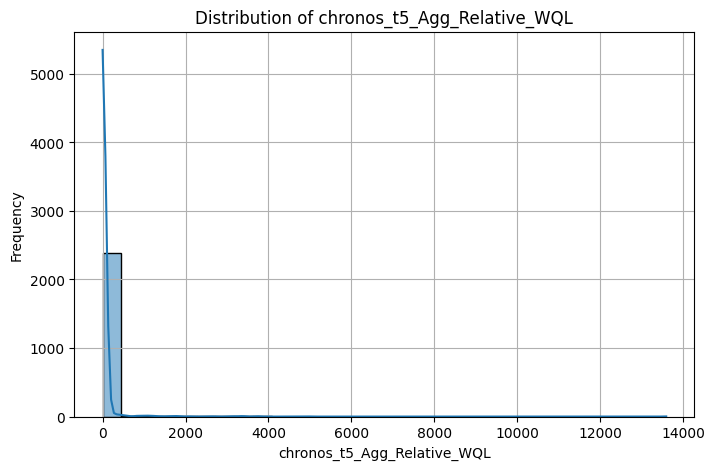

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设df已经加载并包含该列
# 画出 df["chronos_t5_Agg_Relative_WQL"] 的分布图

def plot_distribution(df, column):
    plt.figure(figsize=(8,5))
    sns.histplot(df[column].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# 运行函数示例
plot_distribution(df, "chronos_t5_Agg_Relative_WQL")